# First paper - Composite maps
Seasonal extremes: HNa (winter), Ws (Summer), Wa (highest both), compared to seasonal mean 16 Apr - 15 Oct, 16 Oct - 15 Apr </br>
For paper_v4 overleaf (2022-10-17)

In [356]:
from cdo import Cdo   # python version
cdo = Cdo()

In [289]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

from utils_LH import anomalies_perGWL, GWL_table, rotated_projection_cosmo, cosmo_map_extent, newcmap_OrGy
from utils_LH import Dir, new_lat, new_lon, df_GWL, list_lgcGWL, df_GWL_season
from utils_LH import GWL_groups

In [290]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]  # increase size of inline figure

period = [1995,2017]  # starting - ending year
name_PERIOD = '{}_{}'.format(period[0], period[1])
print(name_PERIOD)

1995_2017


/home/linhho/miniconda3/envs/py3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Timmean: European hourly mean of PV winter 89133.89 and summer 172898.76, wind power winter 182481.34 and summer 120230.24


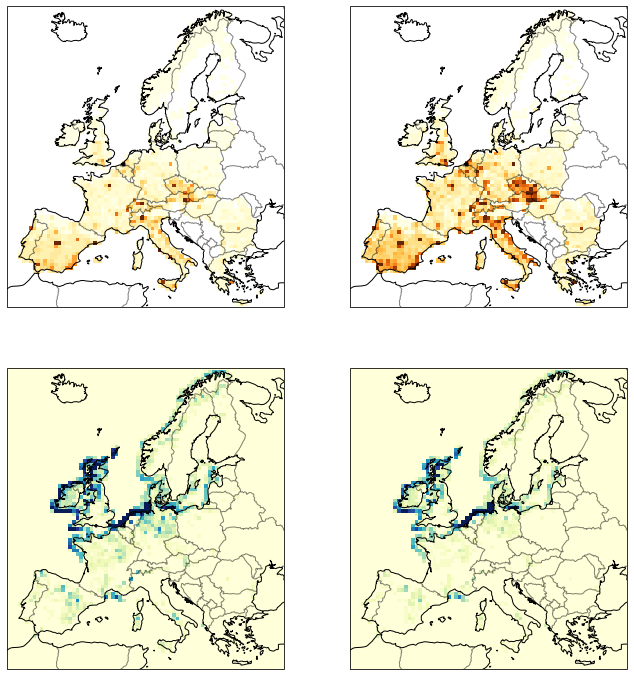

In [221]:
## Map seasonal mean of PV and wind power production

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': rotated_projection_cosmo}, figsize=(10,10))
fig.subplots_adjust(left=0.02, bottom=0.02, right=0.95, top=0.94, wspace=0.05)

# easier to plot, mean over the whole period so any grid with some power should have non-NaN already
var1 = xr.open_dataset('/net/respos/linhho/energy_model/processed/timmean_winter_PV_wind_generation_all.nc')['PV2050'][0,:,:]
var2 = xr.open_dataset('/net/respos/linhho/energy_model/processed/timmean_summer_PV_wind_generation_all.nc')['PV2050'][0,:,:]
var3 = xr.open_dataset('/net/respos/linhho/energy_model/processed/timmean_winter_PV_wind_generation_all.nc')['Wp2050'][0,:,:]
var4 = xr.open_dataset('/net/respos/linhho/energy_model/processed/timmean_summer_PV_wind_generation_all.nc')['Wp2050'][0,:,:]
# var1[var1==0] = np.nan
# var2[var2==0] = np.nan

axs = axs.flatten()

for idx, var in enumerate([var1, var2, var3, var4]):
    
    if (idx==0 or idx==1): my_cmap = plt.cm.get_cmap('YlOrBr', 20)
    else: my_cmap = plt.cm.get_cmap('YlGnBu', 20)
    pl1 = axs[idx].pcolormesh(new_lon, new_lat, var,
                 transform=ccrs.PlateCarree(), cmap=my_cmap)
    axs[idx].coastlines()
    axs[idx].add_feature(cartopy.feature.BORDERS, alpha = 0.5)  #linestyle=':')
    axs[idx].set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map
    pl1.set_clim(0,500)


# fig.tight_layout()
# fig.savefig('Paper1_final_CLIMIXinstalledcapacity_meanPVwindgenerationallperiod_raw.pdf'.format(name_PERIOD), dpi=300, transparent=True)

print("Timmean: European hourly mean of PV winter {:.2f} and summer {:.2f}, wind power winter {:.2f} and summer {:.2f}".format(
    np.nansum(var1), np.nansum(var2), np.nansum(var3), np.nansum(var4)))

In [225]:
# (89.13389*4192 + 172.89876*4209) / 8401  = 131.10107698131176 NOT matched
# (182.48134*4192 + 120.23024*4209) / 8401  = 151.29280531365313 Matched!

151.29280531365313

In [197]:
# Read hourly GWL data, find list of indices for each GWL
df_daily = df_GWL_season.loc[(df_GWL['Year']>=period[0]) & (df_GWL['Year']<=period[1])].copy()  # deep copy to create a real new copy not depend on the old df
df_hourly =  df_daily.set_index('Date').to_period().resample('H').ffill()
df_hourly.reset_index(drop=False, inplace=True)

dict_GWL_id = dict.fromkeys(list_lgcGWL)
for idx, GWL in enumerate(list_lgcGWL):
    dict_GWL_id[GWL] = df_hourly.index[df_hourly['lgcGWL']==GWL]
print(dict_GWL_id['HM'][-5:])

Int64Index([198619, 198620, 198621, 198622, 198623], dtype='int64')


In [267]:
# Dictionary of indices of each weather type by ***SEASON and YEAR*** to select by CDO

# winter

dict_GWL_id_year_winter = dict.fromkeys(list_lgcGWL)
for idx, GWL in enumerate(list_lgcGWL):
    dict_GWL_id_year_winter[GWL] = dict.fromkeys(range(period[0], period[1]+1))
    for year in range(period[0], period[1]+1):
        
        # Create sub-dataframe of that year to get its specific indices
        df_hourly_year = df_hourly[df_hourly['Year']==year].reset_index(drop=True)
        df_hourly_winter = df_hourly_year[df_hourly_year['Season']=='winter']
        dict_GWL_id_year_winter[GWL][year] = df_hourly_winter.index[df_hourly_winter['lgcGWL']==GWL]

# summer

dict_GWL_id_year_summer = dict.fromkeys(list_lgcGWL)
for idx, GWL in enumerate(list_lgcGWL):
    dict_GWL_id_year_summer[GWL] = dict.fromkeys(range(period[0], period[1]+1))
    for year in range(period[0], period[1]+1):
        
        # Create sub-dataframe of that year to get its specific indices
        df_hourly_year = df_hourly[df_hourly['Year']==year].reset_index(drop=True)
        df_hourly_summer = df_hourly_year[df_hourly_year['Season']=='summer']
        dict_GWL_id_year_summer[GWL][year] = df_hourly_summer.index[df_hourly_summer['lgcGWL']==GWL]


In [264]:
# Test
year = 2015
GWL = 'HNa'
df_hourly_year = df_hourly[df_hourly['Year']==year].reset_index(drop=True)
df_hourly_year.iloc[dict_GWL_id_year_summer[GWL][year]]

,Date,Year,Month,Day,id_EGWL,EGWL,id_lgcGWL,lgcGWL,Season
2520,2015-04-16 00:00,2015,4,16,26,HNg,14,HNa,summer
2521,2015-04-16 01:00,2015,4,16,26,HNg,14,HNa,summer
2522,2015-04-16 02:00,2015,4,16,26,HNg,14,HNa,summer
2523,2015-04-16 03:00,2015,4,16,26,HNg,14,HNa,summer
2524,2015-04-16 04:00,2015,4,16,26,HNg,14,HNa,summer
...,...,...,...,...,...,...,...,...,...
3211,2015-05-14 19:00,2015,5,14,26,HNg,14,HNa,summer
3212,2015-05-14 20:00,2015,5,14,26,HNg,14,HNa,summer
3213,2015-05-14 21:00,2015,5,14,26,HNg,14,HNa,summer
3214,2015-05-14 22:00,2015,5,14,26,HNg,14,HNa,summer


## Get timestep of Ws, HNa, Wa only in winter , and in summer separately

In [268]:
### Loop through GWL, selelct only corresponding timestep in COSMO-rea6 48km 1995--2017
import os, glob

list_extreme = [dict_GWL_id_year_summer['Ws'], dict_GWL_id_year_winter['HNa'],  # lowest
                dict_GWL_id_year_summer['Wa'], dict_GWL_id_year_winter['Wa'] ]  # highest

for idx, dict_GWL in enumerate(list_extreme):
    
    if idx==0  : label = 'summer_Ws'
    elif idx==1: label = 'winter_HNa'
    elif idx==2: label = 'summer_Wa'
    else       : label = 'winter_Wa'
        
    # get dataframe of GWL for each year, then get the indices of GWL in that dataframe
    for year in range(period[0], period[1]+1):
        # i+1 because python index is -1 of the usual indexing in CDO
        if  len(dict_GWL[year])==0:
            print('No data of {} in year {}'.format(label, year)); continue
        list_indices_with_comma = ','.join(str(i+1) for i in dict_GWL[year])

        # extract from COSMO-REa6 data only the timestep with selected GWL_extreme
        ifile = '/data/etcc/cosmo-rea6/hourly/48km/{}_COSMO-REA6_hourly_48km.nc'.format(year)
        ofile = '/net/respos/linhho/cosmo-rea6_processed/tmp_COSMO-REA6_hourly_48km_{}.nc'.format(year)
        cdo.seltimestep(list_indices_with_comma, input = ifile, output = ofile)  #, options='-selvar,pmsl')

        # extract from COSMO-REa6 data only the timestep with selected GWL_extreme
        ifile = '/net/respos/linhho/energy_model/{}_PV_wind_generation_v2.nc'.format(year)
        ofile = '/net/respos/linhho/energy_model/processed/tmp_PV_wind_generation_{}.nc'.format(year)
        cdo.seltimestep(list_indices_with_comma, input = ifile, output = ofile)  #, options='-selvar,pmsl')

    # Combine all data from each year into one file == COSMO-REA6
    # then delete temporary files???
    cdo.cat(input = '/net/respos/linhho/cosmo-rea6_processed/tmp_COSMO-REA6_hourly_48km_????.nc', 
            output = '/net/respos/linhho/cosmo-rea6_processed/selected_COSMO-REA6_hourly_48km_{}.nc'.format(label))
    for f in glob.glob('/net/respos/linhho/cosmo-rea6_processed/tmp_COSMO-REA6_hourly_48km_????.nc'):
        os.remove(f)
        
    # Combine all data from each year into one file == energy data
    # then delete temporary files???
    cdo.cat(input = '/net/respos/linhho/energy_model/processed/tmp_PV_wind_generation_????.nc', 
            output = '/net/respos/linhho/energy_model/processed/selected_PV_wind_generation_{}.nc'.format(label))
    for f in glob.glob('/net/respos/linhho/energy_model/processed/tmp_PV_wind_generation_????.nc'):
        os.remove(f)

No data of summer_Ws in year 1998
No data of summer_Ws in year 2001
No data of summer_Ws in year 2006
No data of summer_Ws in year 2008
No data of summer_Ws in year 2011
No data of summer_Ws in year 2017
No data of winter_HNa in year 1999
No data of winter_HNa in year 2004
No data of winter_HNa in year 2005
No data of winter_HNa in year 2007
No data of winter_HNa in year 2014
No data of winter_HNa in year 2015
No data of winter_HNa in year 2017
No data of summer_Wa in year 1997
No data of summer_Wa in year 1999
No data of summer_Wa in year 2005
No data of summer_Wa in year 2007
No data of summer_Wa in year 2010
No data of summer_Wa in year 2014
No data of winter_Wa in year 2010
No data of winter_Wa in year 2013


### Plot of extremes winter and summer

In [291]:
# get MEAN values of MSL pressure and total radiation from pre-calculated CDO in cosmo-rea6/hourly
# mistake lon <-> lat from CFrank
summer_met = xr.open_dataset('/net/respos/linhho/cosmo-rea6_processed/timmean_summer_COSMO-REA6_hourly_48km_all.nc')
winter_met = xr.open_dataset('/net/respos/linhho/cosmo-rea6_processed/timmean_winter_COSMO-REA6_hourly_48km_all.nc')

mean_summer_pmsl = summer_met['pmsl'][0,:,:]
mean_winter_pmsl = winter_met['pmsl'][0,:,:]

mean_summer_radiation = summer_met['total_radiation'][0,:,:]
mean_winter_radiation = winter_met['total_radiation'][0,:,:]

print("Summer: mean pmsl {:.2f};  mean radiation {:.2f}".format(np.nanmean(mean_summer_pmsl), np.nanmean(mean_summer_radiation)))
print("Winter: mean pmsl {:.2f};  mean radiation {:.2f}".format(np.nanmean(mean_winter_pmsl), np.nanmean(mean_winter_radiation)))

Summer: mean pmsl 101375.02;  mean radiation 202.15
Winter: mean pmsl 101453.70;  mean radiation 87.63


In [292]:
# # get MEAN values of MSL pressure and total radiation from pre-calculated CDO in cosmo-rea6/hourly
# # mistake lon <-> lat from CFrank
# summer_met = xr.open_dataset('/net/respos/linhho/cosmo-rea6_processed/timsum_summer_COSMO-REA6_hourly_48km_all.nc')
# winter_met = xr.open_dataset('/net/respos/linhho/cosmo-rea6_processed/timsum_winter_COSMO-REA6_hourly_48km_all.nc')

# mean_summer_pmsl = summer_met['pmsl'][0,:,:]/4209/24
# mean_winter_pmsl = winter_met['pmsl'][0,:,:]/4192/24

# mean_summer_radiation = summer_met['total_radiation'][0,:,:]/4209/24
# mean_winter_radiation = winter_met['total_radiation'][0,:,:]/4192/24

# print("Summer: mean pmsl {:.2f};  mean radiation {:.2f}".format(np.nanmean(mean_summer_pmsl), np.nanmean(mean_summer_radiation)))
# print("Winter: mean pmsl {:.2f};  mean radiation {:.2f}".format(np.nanmean(mean_winter_pmsl), np.nanmean(mean_winter_radiation)))

Summer: mean pmsl 101325.84;  mean radiation 202.05
Winter: mean pmsl 101451.69;  mean radiation 87.63


In [339]:
# # get MEAN seasonal of energy data  = from >>> CDO <<< NOT Matched!!

# summer_energy = xr.open_dataset('/net/respos/linhho/energy_model/processed/timmean_summer_PV_wind_generation_all.nc')
# winter_energy = xr.open_dataset('/net/respos/linhho/energy_model/processed/timmean_winter_PV_wind_generation_all.nc')

# mean_summer_PV = summer_energy['PV2050'][0,:,:]
# mean_summer_Wp = summer_energy['Wp2050'][0,:,:]

# mean_winter_PV = winter_energy['PV2050'][0,:,:]
# mean_winter_Wp = winter_energy['Wp2050'][0,:,:]

# print("Summer: mean PV {:.2f};  mean Wp {:.2f}".format(np.nansum(mean_summer_PV), np.nansum(mean_summer_Wp)))
# print("Winter: mean PV {:.2f};  mean Wp {:.2f}".format(np.nansum(mean_winter_PV), np.nansum(mean_winter_Wp)))

Summer: mean PV 172898.76;  mean Wp 120230.24
Winter: mean PV 89133.89;  mean Wp 182481.34


In [381]:
# get MEAN seasonal of energy data = calculate directly with >>> xarray <<< better but not totally matched 129.306 vs 129.7
summer_energy = xr.open_dataset('/net/respos/linhho/energy_model/processed/summer_PV_wind_generation_all.nc')
winter_energy = xr.open_dataset('/net/respos/linhho/energy_model/processed/winter_PV_wind_generation_all.nc')

## mean_summer_PV from xarray here 170, from timmean 172, from timsum/len 171 ???
# mean_summer_PV = np.nansum(summer_energy['PV2050'][:,:,:], axis=0)/len(summer_energy['time'])
# mean_summer_Wp = np.nansum(summer_energy['Wp2050'][:,:,:], axis=0)/len(summer_energy['time'])

mean_winter_PV = np.nansum(winter_energy['PV2050'][:,:,:], axis=0)/len(summer_energy['time'])
mean_winter_Wp = np.nansum(winter_energy['Wp2050'][:,:,:], axis=0)/len(summer_energy['time'])

print("Summer: mean PV {:.2f};  mean Wp {:.2f}".format(np.nansum(mean_summer_PV), np.nansum(mean_summer_Wp)))
print("Winter: mean PV {:.2f};  mean Wp {:.2f}".format(np.nansum(mean_winter_PV), np.nansum(mean_winter_Wp)))

Summer: mean PV 170177.18;  mean Wp 120230.83
Winter: mean PV 88600.72;  mean Wp 181741.99


In [294]:
np.where(mean_winter_Wp==0)

(array([  0,   0,   0, ..., 102, 102, 102]),
 array([  0,   1,   2, ..., 103, 104, 105]))

In [286]:
mean_winter_Wp 

<xarray.DataArray 'Wp2050' (lon: 103, lat: 106)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2006-04-01T23:30:00
Dimensions without coordinates: lon, lat
Attributes:
    units:         MW
    cell_methods:  time: mean
    name:          Power production of wind power in Europe planned -TOTAL- 2...

In [295]:
dir_cosmo_processed  = '/net/respos/linhho/cosmo-rea6_processed/'
dir_energy_processed = '/net/respos/linhho/energy_model/processed/'

In [397]:
# prepare met and energy for GWL extreme
# read data only timesteps of selected GWL
GWL_extreme = 'summer_Ws'
title = "Summer Ws"

# Meteorological data
fname_GWL = dir_cosmo_processed + 'selected_COSMO-REA6_hourly_48km_{}.nc'.format(GWL_extreme)
ds_GWL = xr.open_dataset(fname_GWL)

pmsl_contour = np.sum(ds_GWL['pmsl'], axis=0)/len(ds_GWL['time'])/100
rad_shading = np.sum(ds_GWL['total_radiation'], axis=0)/len(ds_GWL['time']) - mean_summer_radiation

# Energy data
fname_PV_wp = dir_energy_processed + 'selected_PV_wind_generation_{}.nc'.format(GWL_extreme)
ds_PV_wp = xr.open_dataset(fname_PV_wp)
total = ds_PV_wp['PV2050'].fillna(0) + ds_PV_wp['Wp2050']
total_summer_mean = mean_summer_PV + mean_summer_Wp 

toplot1 = np.nansum(total, axis=0) / len(ds_PV_wp['time']) - total_summer_mean;                 
toplot2 = np.nansum(ds_PV_wp['PV2050'],axis=0) / len(ds_PV_wp['time']) - mean_summer_PV;        
toplot3 = np.nansum(ds_PV_wp['Wp2050'],axis=0) / len(ds_PV_wp['time']) - mean_summer_Wp;        

toplot1 = toplot1.astype('float'); toplot2 = toplot2.astype('float'); toplot3 = toplot3.astype('float')
toplot1[toplot1==0] = np.nan ; toplot2[toplot2==0] = np.nan ; toplot3[toplot3==0] = np.nan  # for nd.array
# toplot1 = np.where(toplot1 != 0) ; toplot2 = np.where(toplot2 != 0) ; toplot3 = np.where(toplot3 != 0)

print('{} min and max anomalies total {:.2f} to {:.2f}, PV {:.2f} to {:.2f}, wind power {:.2f} to {:.2f}'.
      format(title, np.nanmin(toplot1), np.nanmax(toplot1), np.nanmin(toplot2), np.nanmax(toplot2), np.nanmin(toplot3), np.nanmax(toplot3)))
print('Met min - max pmsl {:.2f} and {:.2f}, anomalies radiation {:.2f} and {:.2f}'.
      format(np.nanmin(pmsl_contour), np.nanmax(pmsl_contour), np.nanmin(rad_shading), np.nanmax(rad_shading)))

Summer Ws min and max anomalies total -631.36 to 213.85, PV -450.62 to 18.61, wind power -631.36 to 215.62
Met min - max pmsl 1006.05 and 1021.30, anomalies radiation -73.27 and 33.63


In [402]:
# prepare met and energy for GWL extreme
# read data only timesteps of selected GWL
GWL_extreme = 'winter_HNa'
title = "Winter HNa"

# Meteorological data
fname_GWL = dir_cosmo_processed + 'selected_COSMO-REA6_hourly_48km_{}.nc'.format(GWL_extreme)
ds_GWL = xr.open_dataset(fname_GWL)

pmsl_contour = np.sum(ds_GWL['pmsl'], axis=0)/len(ds_GWL['time'])/100
rad_shading = np.sum(ds_GWL['total_radiation'], axis=0)/len(ds_GWL['time']) - mean_winter_radiation

# Energy data
fname_PV_wp = dir_energy_processed + 'selected_PV_wind_generation_{}.nc'.format(GWL_extreme)
ds_PV_wp = xr.open_dataset(fname_PV_wp)
total = ds_PV_wp['PV2050'].fillna(0) + ds_PV_wp['Wp2050']
total_winter_mean = mean_winter_PV + mean_winter_Wp 

toplot1 = np.nansum(total, axis=0) / len(ds_PV_wp['time']) - total_winter_mean;                  
toplot2 = np.nansum(ds_PV_wp['PV2050'],axis=0) / len(ds_PV_wp['time']) - mean_winter_PV;        
toplot3 = np.nansum(ds_PV_wp['Wp2050'],axis=0) / len(ds_PV_wp['time']) - mean_winter_Wp;         

toplot1 = toplot1.astype('float'); toplot2 = toplot2.astype('float'); toplot3 = toplot3.astype('float')
toplot1[toplot1==0] = np.nan ; toplot2[toplot2==0] = np.nan ; toplot3[toplot3==0] = np.nan  # for nd.array
# toplot1 = toplot1.where(toplot1 != 0) ; toplot2 = np.where(toplot2 != 0) ; toplot3 = np.where(toplot3 != 0)

print('{} min and max anomalies total {:.2f} to {:.2f}, PV {:.2f} to {:.2f}, wind power {:.2f} to {:.2f}'.
      format(title, np.nanmin(toplot1), np.nanmax(toplot1), np.nanmin(toplot2), np.nanmax(toplot2), np.nanmin(toplot3), np.nanmax(toplot3)))
print('Met min - max pmsl {:.2f} and {:.2f}, anomalies radiation {:.2f} and {:.2f}'.
      format(np.nanmin(pmsl_contour), np.nanmax(pmsl_contour), np.nanmin(rad_shading), np.nanmax(rad_shading)))

Winter HNa min and max anomalies total -1366.91 to 110.64, PV -290.07 to 26.39, wind power -1366.91 to 110.64
Met min - max pmsl 998.16 and 1025.50, anomalies radiation -52.46 and 6.24


In [327]:
aa = np.nansum(ds_PV_wp['Wp2050'],axis=0)
aa.shape

(103, 106)

In [338]:
# mean_winter_Wp.shape
mean_winter_Wp = mean_winter_Wp.where(mean_winter_Wp!=0)

### Stats for colour bar

Lowest summer: Ws 
- min and max anomalies total -472.33 to 212.05, PV -472.41 to 12.76, wind power -631.19 to 215.62
- Met min - max pmsl 1006.05 and 1021.30, anomalies radiation -73.27 and 33.63

Lowest winter: HNa 
- min and max anomalies total -523.25 to 81.97, PV -294.73 to 25.23, wind power -1377.53 to 107.90
- Met min - max pmsl 998.16 and 1025.50, anomalies radiation -52.46 and 6.24

Highest summer: Wa 
- min and max anomalies total -91.86 to 409.63, PV -58.44 to 195.84, wind power -168.04 to 669.76
- Met min - max pmsl 1001.31 and 1024.53, anomalies radiation -68.25 and 46.67

Highest winter: Wa 
- min and max anomalies total -199.67 to 666.78, PV -67.47 to 103.86, wind power -221.62 to 1308.26
- Met min - max pmsl 989.70 and 1029.21, anomalies radiation -29.65 and 18.87

<ipython-input-403-48f6bcacd172>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.05, bottom=0.02, right=0.95, top=0.94, wspace=0.05)
/home/linhho/miniconda3/envs/py3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


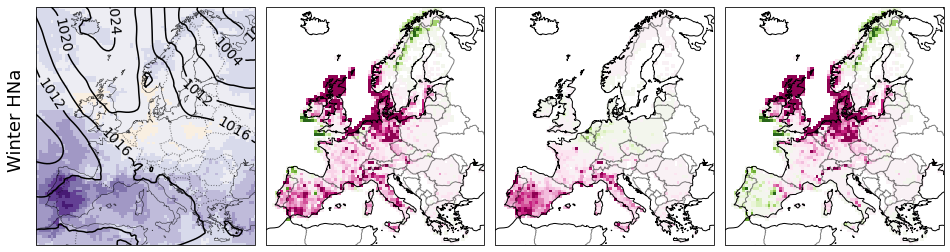

In [403]:
clevs = np.arange(960,1030,4)
pressure_color = 'black'

fig = plt.figure(constrained_layout=True, figsize=(14,4))
widths = [5,5,5,5]
heights = [5]
spec = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=widths, height_ratios=heights, figure=fig)
fig.subplots_adjust(left=0.05, bottom=0.02, right=0.95, top=0.94, wspace=0.05)

#########################################
#   Meteorological condition
#########################################
colorbar_range = [-60, 60] 
my_cmap = plt.get_cmap('PuOr_r', 16)

ax00 = fig.add_subplot(spec[0,0], projection=rotated_projection_cosmo)  
mesh = ax00.pcolormesh(new_lon, new_lat, rad_shading,
             transform=ccrs.PlateCarree(), cmap=my_cmap, zorder=0, vmin=colorbar_range[0], vmax=colorbar_range[1])
ax00.coastlines(alpha=.7, linewidth=.6)
ax00.add_feature(cartopy.feature.BORDERS, alpha = 0.5, linestyle=':')
ax00.set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map


cs = ax00.contour(new_lon, new_lat, pmsl_contour, clevs, linewidths=1.5, colors=pressure_color,
             transform=ccrs.PlateCarree())
ax00.clabel(cs, inline=1, fmt='%.0f', fontsize=14)  #, colors='green')
# ax00 = plt.colorbar(mesh, orientation='horizontal', shrink = col_bar_shrink, pad = 0.1, aspect=12, extend='both') 

#########################################
#   total PV + Wp(2050) annual
#########################################
# setting for total, PV, wind power
col_bar_shrink = 1.2
colorbar_range = [-60, 60]  # [-PV_range, PV_range]
my_cmap = plt.get_cmap('PiYG',20)

ax01 = fig.add_subplot(spec[0,1], projection=rotated_projection_cosmo)
mesh2 = ax01.pcolormesh(new_lon, new_lat, toplot1,
             transform=ccrs.PlateCarree(), cmap=my_cmap, zorder=0, vmin=colorbar_range[0], vmax=colorbar_range[1])
#     my_cmap.set_over("#E50000") )
ax01.coastlines()
ax01.add_feature(cartopy.feature.BORDERS, alpha = 0.5)  #linestyle=':')
ax01.set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map
#     ax01.set_title('Total')

#########################################
#   PV
#########################################

ax02 = fig.add_subplot(spec[0,2], projection=rotated_projection_cosmo)
mesh2 = ax02.pcolormesh(new_lon, new_lat, toplot2,
             transform=ccrs.PlateCarree(), cmap=my_cmap, zorder=0, vmin=colorbar_range[0], vmax=colorbar_range[1])
#     my_cmap.set_over("#E50000")
ax02.coastlines()
ax02.add_feature(cartopy.feature.BORDERS, alpha = 0.5)  #linestyle=':')
ax02.set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map
#     ax02.set_title('PV power')

# # Colourbar 
# ########################################
# ax01 = plt.colorbar(mesh, orientation='horizontal', shrink = col_bar_shrink, pad = 0.1, aspect=12, extend='both') #,
# #                        ticks=[-0.2, -0.1, 0, 0.1, 0.2])
# ax01.set_label('Power anomalies [MW]')

#########################################
#   Wind power
#########################################

ax03 = fig.add_subplot(spec[0,3], projection=rotated_projection_cosmo)
mesh2 = ax03.pcolormesh(new_lon, new_lat, toplot3,
             transform=ccrs.PlateCarree(), cmap=my_cmap, zorder=0, vmin=colorbar_range[0], vmax=colorbar_range[1])
#     my_cmap.set_over("#E50000")
ax03.coastlines()
ax03.add_feature(cartopy.feature.BORDERS, alpha = 0.5)  #linestyle=':')
ax03.set_extent(cosmo_map_extent, crs=rotated_projection_cosmo)  # boundary of the map
#     ax03.set_title('Wind power')

fig.text(0.03, 0.5, title, ha='center', va='center', rotation='vertical', fontsize=18)
# fig.tight_layout()

fig.savefig('Paper1_v4_Fig4_Composite_map_extreme_meteological_{}_{}.pdf'.format(name_PERIOD, GWL_extreme), dpi=200, transparent=True)


<ipython-input-384-d7a7cb23123e>:4: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  ax01 = plt.colorbar(mesh, orientation='horizontal', shrink = col_bar_shrink, pad = 0.1, aspect=12, extend='both',
<ipython-input-384-d7a7cb23123e>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Paper1_v4_Fig4_Composite_map_ONLY_colourbar_pmslrad.pdf', dpi=200, transparent=True, figsize=(3,1))


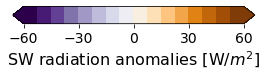

In [384]:
fig = plt.figure(constrained_layout=True, figsize=(3.5,3))
my_cmap = plt.get_cmap('PuOr_r', 16)
plt.gca().set_visible(False)
ax01 = plt.colorbar(mesh, orientation='horizontal', shrink = col_bar_shrink, pad = 0.1, aspect=12, extend='both',
                       ticks=[-60, -30, 0, 30, 60], cmap=my_cmap)
ax01.ax.tick_params(labelsize=14)
ax01.set_label('SW radiation anomalies [W/$m^2$]', fontsize=16)
plt.savefig('Paper1_v4_Fig4_Composite_map_ONLY_colourbar_pmslrad.pdf', dpi=200, transparent=True, figsize=(3,1))


<ipython-input-401-f99b7719c834>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Paper1_v4_Fig4_Composite_map_ONLY_colourbar_power.pdf', dpi=200, transparent=True, figsize=(3,1))


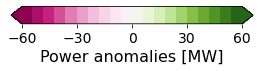

In [401]:
fig = plt.figure(constrained_layout=True, figsize=(3.5,3))
plt.gca().set_visible(False)
ax01 = plt.colorbar(mesh2, orientation='horizontal', shrink = col_bar_shrink, pad = 0.1, aspect=12, extend='both',
                       ticks=[-60, -30, 0, 30, 60])
ax01.ax.tick_params(labelsize=14)
ax01.set_label('Power anomalies [MW]', fontsize=16)
plt.savefig('Paper1_v4_Fig4_Composite_map_ONLY_colourbar_power.pdf', dpi=200, transparent=True, figsize=(3,1))


In [ ]:
## annual